In [1]:
# Extract data from zip file
import zipfile

with zipfile.ZipFile('data/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall("./data")

In [17]:
# IMPORT PACKAGES
import os

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as transforms



In [ ]:
def load_data(root, datatype, categories, use_cached=True):
    # if use_cached:
    #     try:
    #         x = np.load(os.path.join(root, f'X_{datatype}.npy'))
    #         y = np.load(os.path.join(root, f'Y_{datatype}.npy'))
    #         return x, y
    #     except FileNotFoundError as _:
    #         warnings.warn('Cached data does not exist! Loading from raw data.')

    x, y = [], []
    num_classes = len(categories)
    for index, category in enumerate(categories):
        category_path = os.path.join(root, datatype, category)
        for filename in os.scandir(category_path):
            # Load data
            filedata = np.load(filename.path)
            x.append(filedata)

            # Load label (Convert into onehot)
            label = np.stack([np.eye(num_classes)[index]
                              for _ in range(len(filedata))], axis=0)
            y.append(label)
    x = np.expand_dims(np.concatenate(x, axis=0), axis=-1) # add channel axis
    y = np.concatenate(y, axis=0)

    # Save
    np.save(os.path.join(root, f'X_{datatype}.npy'), x)
    np.save(os.path.join(root, f'Y_{datatype}.npy'), y)

    return x, y

In [ ]:
# Check data dimensions

# Initialize lists for each folder
FOLDERS = ['no', 'sphere', 'vort']
# FOLDERS = ['vort']
# IMG_NUM = 5

folder_data = {"data": [], "labels": []}
prefix = "data/train"

for (i, folder) in enumerate(FOLDERS):

    files = os.listdir(os.path.join(prefix, folder))
    # files = files[:IMG_NUM]

    for file in files:
        data = np.load(os.path.join(prefix, folder, file))
        folder_data["data"].append(data)
        folder_data["labels"].append(i)
    
folder_data["data"] = np.array(folder_data["data"])
folder_data["labels"] = np.array(folder_data["labels"])

In [ ]:
folder_data["data"].shape[0]

In [ ]:
img = folder_data["data"][0].transpose((1,2,0))
# img = Image.fromarray(img)
# print(img.size)
# .transpose((1,2,0))
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(40)
                               ])

img = transform(img)
img.shape

In [ ]:
merged = []

# Convert to np arrays & join
for folder_list in folder_data.values():
    print(len(folder_list))
    merged.extend(folder_list)

merged = np.array(merged)


merged.shape

3 x 10,000 greyscale 150x150 images. Plot 15 of these in a 3x5 grid to see examples of each class

In [ ]:
IMGS_IN_ROW = 5

fig, axes = plt.subplots(int(merged.shape[0]/IMGS_IN_ROW), IMGS_IN_ROW, sharex='all', sharey='all', figsize=(20,15))
plt.axis('off')

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(merged[i][0])


plt.tight_layout()
plt.show()

-----------------------------------------------DATALOADER-----------------------------------------------------------

In [2]:
class LensData(Dataset):
    def __init__(self, train=True, transform=None):

        self.transform = transform

        # Initialize lists for each folder
        FOLDERS = ['no', 'sphere', 'vort']
        # FOLDERS = ['vort']
        # IMG_NUM = 5

        prefix = "data/train"

        data = []
        labels = []

        for (i, folder) in enumerate(FOLDERS):

            files = os.listdir(os.path.join(prefix, folder))

            for (k, file) in enumerate(files):
                if k == 10:
                    break
                im = np.load(os.path.join(prefix, folder, file))
                data.append(im)
                labels.append(i)

        data = np.array(data).transpose((0, 2, 3, 1))
        labels = np.array(labels)

        data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

        if train:
            self.data = data_train
            self.labels = labels_train

        else:
            self.data = data_test
            self.labels = labels_test



    #len(dataset) returns the size of the dataset
    #The __len__ function returns the number of samples in our dataset
    def __len__(self):
        return len(self.labels)


    #This will return a given image and a corrosponding index for the image
    #__getitem__ to support the indexing such that dataset[i] can be used to get ith sample.
    def __getitem__(self, i):
        # img = io.imread(self.data[index])
        # print(self.data[index].shape)
        # print(np.squeeze(self.data[index], axis=2).shape)

        img = self.data[i]

        labels = self.labels[i]

        if self.transform is not None:
            img = self.transform(img)

        return img, labels

In [ ]:
dataset = LensData(False, 
                   transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(100),
                ]),)

train_loader = DataLoader(dataset, batch_size=2)

for batch_idx, (train_data, labels) in enumerate(train_loader): #from training dataset
    # data, labels = train_data[0], labels
    print(train_data.shape)

In [18]:
class Lens:

    def __init__(self, batch_size=1, shuffle=False, num_workers=1, crop_size=150, img_size=150, rotation_degrees=0, translate=(0.0, 0.0), scale=(1.0, 1.0)):

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.num_workers = num_workers

        self.crop_size = crop_size
        self.img_size = img_size
        self.rotation = rotation_degrees
        self.translate = translate
        self.scale = scale


    def __call__(self):

        train_loader = DataLoader(
            LensData(
                train=True,
                
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.RandomAffine(
                        degrees=self.rotation, 
                        translate=self.translate,
                        scale=self.scale
                    ),
                    transforms.CenterCrop(self.crop_size),
                    transforms.Resize(self.img_size),
                ]),
            ),
            
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers
        )


        test_loader = DataLoader(
            LensData(
                train=False,
                
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.CenterCrop(self.crop_size),
                    transforms.Resize(self.img_size),
                ]),
            ),
            
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            num_workers=self.num_workers
        )
        
        return train_loader, test_loader, self.img_size

2, 2, 1, 0, 

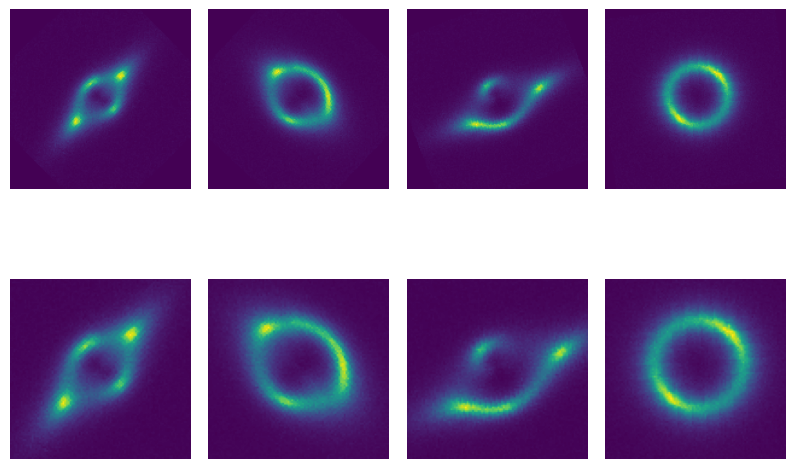

In [44]:
# AUGMENTED IMAGE EXPLORATION

train_loader, test_loader, img_size = Lens(rotation_degrees=45)()


samples = 4
starting_index = 0

fig, axs = plt.subplots(2, samples, figsize=(10,7))
fig.subplots_adjust(wspace=0.1, hspace=0.0)
axs = axs.ravel()

toPIL = transforms.ToPILImage()

for i in range(starting_index, starting_index + samples):
    #* print label
    print(train_loader.dataset[i][1], end=', ')
    original = train_loader.dataset[i][0]
    transformed = transforms.Compose([
        transforms.CenterCrop(100),
        transforms.RandomAffine(
        degrees=0,
        # translate=(0.15,0.15),
        # scale=(0.95, 1.1)
    )])(original)
    
    ii = (i-starting_index)

    axs[ii].imshow(toPIL(original))
    axs[ii].axis('off')

    axs[ii+samples].imshow(toPIL(transformed))
    axs[ii+samples].axis('off')

plt.show()